# Example: Buck converter

Example created by Gabriel Bueno Leandro

## Reference 

**The following text was taken from the link https://www.researchgate.net/publication/216771768_Multiobjective_parameter_estimation_for_nonlinear_systems_Affine_information_and_least-squares_formulation**. 



In [1]:
# Importing the libraries and methods needed to run the notebook.
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sysidentpy.model_structure_selection import FROLS
from sysidentpy.multiobjective.multiobjective_parameter_estimation import IM
from sysidentpy.basis_function._basis_function import Polynomial
from sysidentpy.utils.display_results import results
from sysidentpy.utils.plotting import plot_results
from sysidentpy.metrics import root_relative_squared_error

# Dynamic Behavior

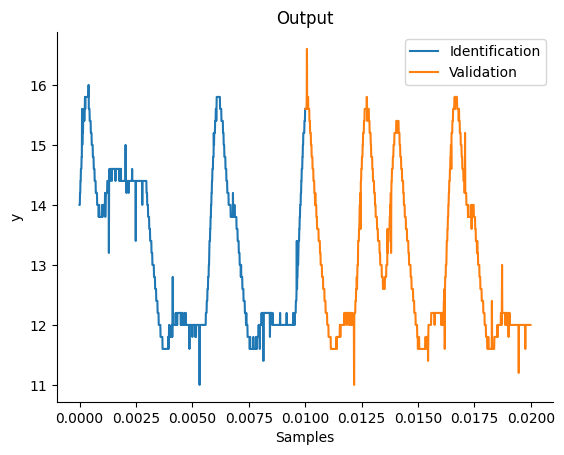

In [2]:
# Reading Buck's input and output data
dados = pd.read_csv(r'datasets/buck.txt' , sep=" ", header=None).to_numpy()
dados_val = pd.read_csv("datasets/buck_val.txt" , sep =" ", header=None).to_numpy()

# Separating the identification data
dados_amostras = dados[:, 2]
dados_saida = dados[:, 6]
dados_entrada = dados[:, 4]

# Separating the validation data
dados_amostras_val = dados_val[:, 2]
dados_saida_val = dados_val[:, 6]
dados_entrada_val = dados_val[:, 4]

# Plotting the measured output (identification and validation data)
plt.figure(1)
plt.title('Output')
plt.plot(dados_amostras,dados_saida, label='Identification', linewidth=1.5)
plt.plot(dados_amostras_val,dados_saida_val, label='Validation', linewidth=1.5)
plt.xlabel('Samples')
plt.ylabel('y')
plt.legend()
plt.show()


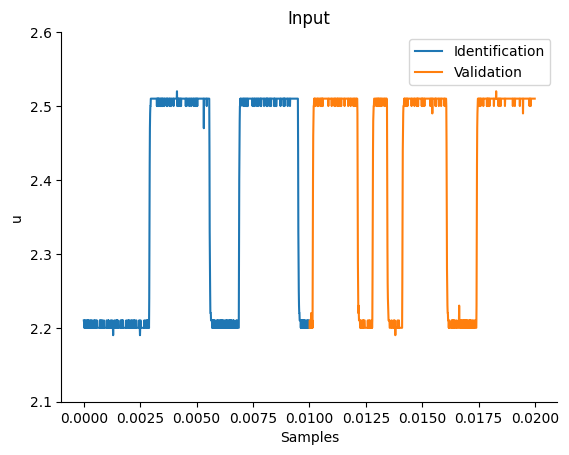

In [3]:
# Plotting the measured input(identification and validation data)
plt.figure(2)
plt.title('Input')
plt.plot(dados_amostras, dados_entrada, label='Identification', linewidth=1.5)
plt.plot(dados_amostras_val, dados_entrada_val, label='Validation', linewidth=1.5)
plt.ylim(2.1, 2.6)
plt.ylabel('u')
plt.xlabel('Samples')
plt.legend()
plt.show()

## Buck Converter Static Function

The duty cycle is defined by $D=\frac{T_{on}}{T}$ and its complement is $D'=\frac{T_{off}}{T}$ , where T is the operation cycle. The load voltage $V_o$ relates to the source voltage $V_d$ as $V_o = D\cdot V_d = (1 − D’)\cdot V_d$. This converter satisfies $D' = \frac{\bar{u}-1}{3}$ and therefore the static function of this system is known from theory to be:
$$
V_o = \frac{4V_d}{3} - \frac{V_d}{3}\cdot \bar{u}
$$

assuming $V_d = 24\:V $, the expression can be rewritten as follows:

$$
V_o = (4 - \bar{u})\cdot 8
$$

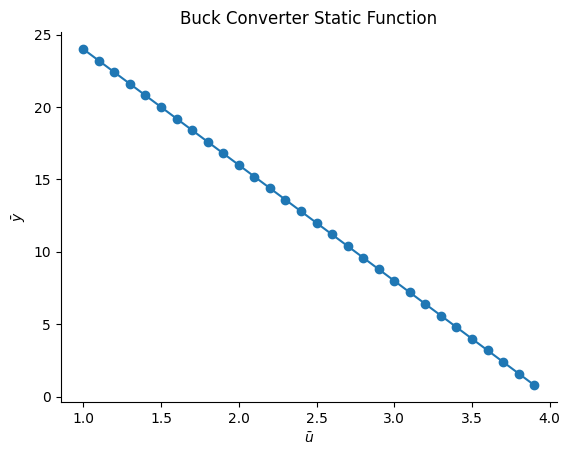

In [4]:
# Static data
Vd = 24
Yo = np.zeros(30)
Uo = np.zeros(30)
for t in range(10, 40):
    Uo[t-10] = (t)/10
    Yo[t-10] = (4-Uo[t-10])*Vd/3
Uo = Uo.reshape(-1, 1)
Yo = Yo.reshape(-1, 1)
plt.figure(3)
plt.title('Buck Converter Static Function')
plt.xlabel('$\\bar{u}$')
plt.ylabel('$\\bar{y}$')
plt.plot(Uo, Yo, linewidth=1.5, linestyle='-', marker='o')
plt.show()

# Buck converter static gain

The gain of the Buck converter can be described as the derivative of the static function, which is described by:

$$
V_o = (4 - \bar{u})\cdot 8
$$

soon $gain=V_o'=-8$


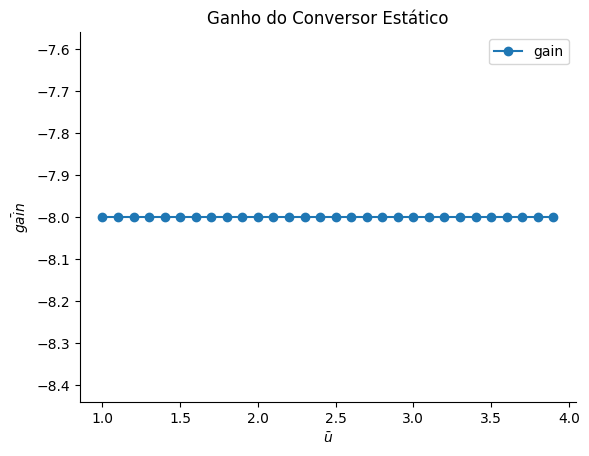

In [5]:
# Definindo o ganho
gain = -8*np.ones(len(Uo)).reshape(-1, 1)
plt.figure(3)
plt.title('Ganho do Conversor Estático')
plt.xlabel('$\\bar{u}$')
plt.ylabel('$\\bar{gain}$')
plt.plot(Uo, gain, linewidth=1.5, label='gain', linestyle='-', marker='o')
plt.legend()
plt.show()

Information about static function and static gain, together with the usual input/output data, have been used as sources of affine information to estimate the parameters of the model. The composite cost function is:

$$
\gamma(\hat\theta) = w_1\cdot J_{LS}(\hat{\theta})+w_2\cdot J_{SF}(\hat{\theta})+w_3\cdot J_{SG}(\hat{\theta})
$$


In [6]:
# Informing test and validation data
x_train = dados_entrada.reshape(-1, 1)
y_train = dados_saida.reshape(-1, 1)
x_valid = dados_entrada_val.reshape(-1, 1)
y_valid = dados_saida_val.reshape(-1, 1)

basis_function = Polynomial(degree=2)

model = FROLS(
    order_selection=True,
    n_info_values=10,
    extended_least_squares=False,
    ylag=2, xlag=2,
    info_criteria='aic',
    estimator='least_squares',
    basis_function=basis_function
)

model.fit(X=x_train, y=y_train)

The next step will be to determine the weights of the objectives of interest:

In [7]:
# Matrix with the weights.
W = np.array([[0.98, 0.7, 0.5, 0.35, 0.25, 0.01, 0.15, 0.01],
              [0.01, 0.1, 0.3, 0.15, 0.25, 0.98, 0.35, 0.01],
              [0.01, 0.2, 0.2, 0.50, 0.50, 0.01, 0.50, 0.98]])


with the parameters all in hand, we can already calculate the parameters in a multiobjective way:

In [8]:
# Calling the class referring to the calculation of the parameters via the multiobjective technique

g = IM(y_train=y_train[2:],
       gain=gain,y_static=Yo,
       x_static=Uo, psi=model.psi,
       n_inputs=model._n_inputs,
       non_degree=model.non_degree,
       model_type=model.model_type,
       final_model = model.final_model,
       W=W)


now the method will be called to calculate the matrix of the performance of the objectives (J), weights (w), the Euclidean norm (E), the thetas referring to each weight (Theta), matrix H multiplied by R and the matrix Q multiplied by R.


In [9]:
# Method to calculate the parameters
J, w, E, Theta, HR, QR = g.affine_information_least_squares()
result = {'w1': w[0,:],
          'w2': w[2,:],
          'w3': w[1,:],
          'J_ls': J[0,:],
          'J_sg': J[1,:],
          'J_sf': J[2,:],
          '||J||:': E}
pd.DataFrame(result)

,w1,w2,w3,J_ls,J_sg,J_sf,||J||:
0,0.98,0.01,0.01,0.960437,5.567861e-05,0.187816,0.978629
1,0.70,0.20,0.10,0.966245,4.964073e-03,0.062240,0.968260
2,0.50,0.20,0.30,0.978734,9.795589e-03,0.011696,0.978853
3,0.35,0.50,0.15,0.978519,8.077210e-04,0.023455,0.978800
4,0.25,0.50,0.25,0.989026,7.029604e-04,0.007045,0.989052
5,0.01,0.01,0.98,1.000000,4.524682e-03,0.000005,1.000010
6,0.15,0.50,0.35,0.997511,3.503033e-04,0.001781,0.997512
7,0.01,0.98,0.01,0.991194,3.232136e-07,0.007699,0.991224


now we can choose a theta value referring to the weights:

In [10]:
# Escrevendo os resultados
model.theta = Theta[0, :].reshape(-1,1)
yhat = model.predict(X=x_valid, y=y_valid)
rrse = root_relative_squared_error(y_valid, yhat)
r = pd.DataFrame(
    results(
        model.final_model, model.theta, model.err,
        model.n_terms, err_precision=3, dtype='sci'
        ),
    columns=['Regressors', 'Parameters', 'ERR'])
r

,Regressors,Parameters,ERR
0,y(k-1),3.9056E-01,9.999E-01
1,y(k-2),6.0302E-01,2.042E-05
2,x1(k-1)y(k-1),-3.0060E-02,1.108E-06
3,1,6.9426E-01,4.688E-06
4,y(k-1)^2,2.7689E-01,3.922E-07
5,x1(k-1),3.0098E-02,8.389E-07
6,y(k-2)y(k-1),-5.3620E-01,5.690E-07
7,y(k-2)^2,2.6074E-01,3.827E-06


dynamic data in graphical form:

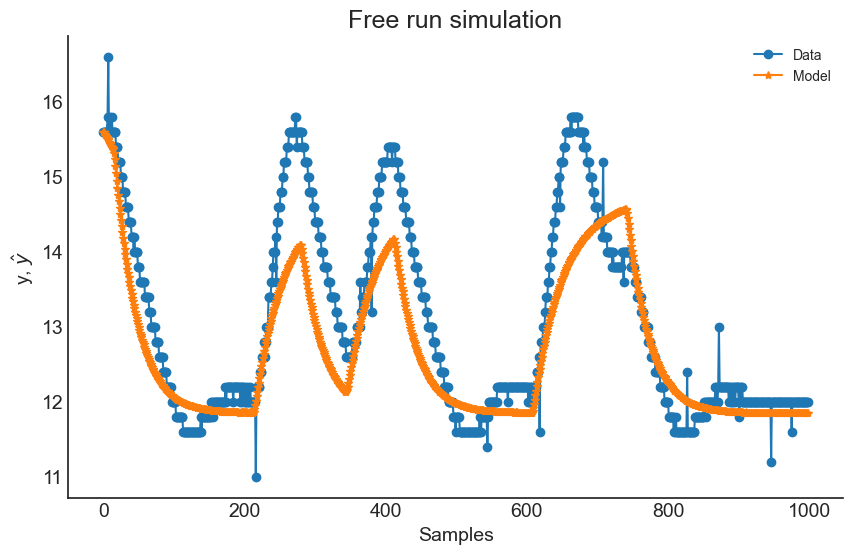

In [11]:
plot_results(y=y_valid, yhat=yhat, n=1000)

the static gain graphically:

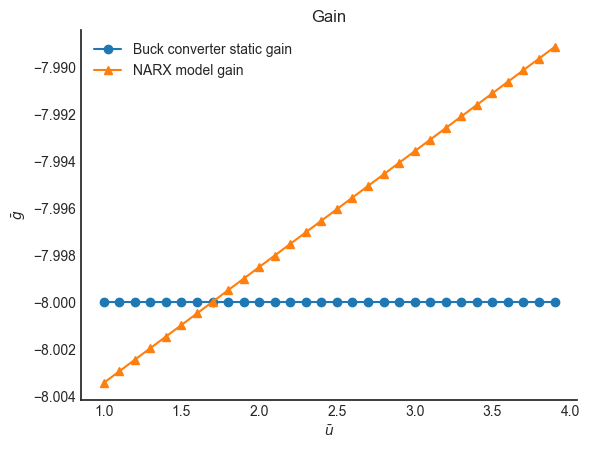

In [12]:
plt.figure(4)
plt.title('Gain')
plt.plot(Uo, gain, linewidth=1.5, linestyle='-', marker='o', label='Buck converter static gain')
plt.plot(Uo, HR.dot(model.theta),  linestyle='-', marker='^', linewidth=1.5, label='NARX model gain')
plt.xlabel('$\\bar{u}$')
plt.ylabel('$\\bar{g}$')
plt.legend()
plt.show()

the static function graphically:

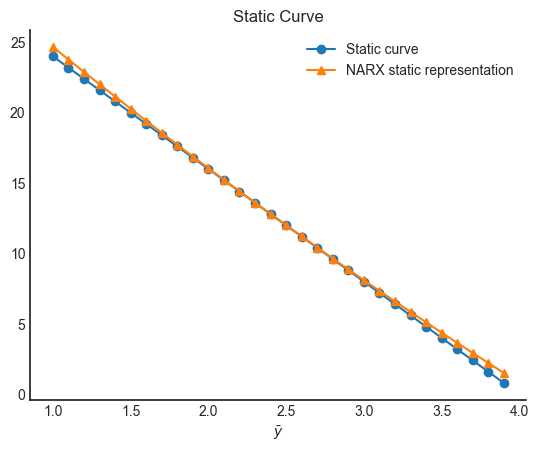

In [13]:
plt.figure(5)
plt.title('Static Curve')
plt.plot(Uo, Yo, linewidth=1.5, label='Static curve',  linestyle='-', marker='o')
plt.plot(Uo, QR.dot(model.theta), linewidth=1.5, label='NARX ​​static representation', linestyle='-', marker='^')
plt.xlabel('$\\bar{u}$')
plt.xlabel('$\\bar{y}$')
plt.legend()
plt.show()

pareto-optimal curve:

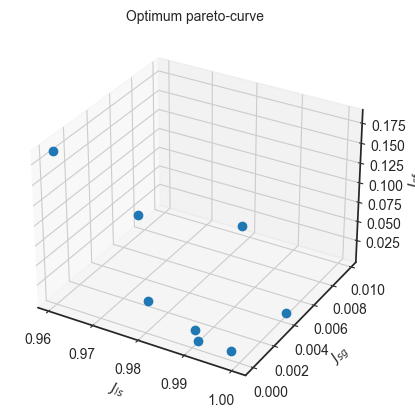

In [14]:
plt.figure(6)
ax = plt.axes(projection='3d')
ax.plot3D( J[0,:],  J[1,:],  J[2,:], 'o', linewidth=2)
ax.set_title('Optimum pareto-curve', fontsize=10)
ax.set_xlabel('$J_{ls}$', fontsize=10)
ax.set_ylabel('$J_{sg}$', fontsize=10)
ax.set_zlabel('$J_{sf}$', fontsize=10)
plt.show()